In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
data = "Data/nfl_stadiums.csv"
data2 = "Data/nfl_teams.csv"
data3 = "Data/spreadspoke_scores.csv"

dfstad = pd.read_csv(data, encoding="unicode_escape")
dfteam = pd.read_csv(data2)
dfscore = pd.read_csv(data3)

<IPython.core.display.Javascript object>

In [5]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12934 non-null  object 
 1   schedule_season      12934 non-null  int64  
 2   schedule_week        12934 non-null  object 
 3   schedule_playoff     12934 non-null  bool   
 4   team_home            12934 non-null  object 
 5   score_home           12797 non-null  float64
 6   score_away           12797 non-null  float64
 7   team_away            12934 non-null  object 
 8   team_favorite_id     10318 non-null  object 
 9   spread_favorite      10318 non-null  float64
 10  over_under_line      10308 non-null  object 
 11  stadium              12934 non-null  object 
 12  stadium_neutral      12934 non-null  bool   
 13  weather_temperature  12008 non-null  float64
 14  weather_wind_mph     12008 non-null  float64
 15  weather_humidity     8388 non-null  

<IPython.core.display.Javascript object>

In [6]:
dfscore = dfscore.replace(r"^\s*$", np.nan, regex=True)
dfscore = dfscore.drop(
    columns=[
        "weather_humidity",
        "weather_detail",
        "weather_temperature",
        "weather_wind_mph",
        "schedule_date",
        "schedule_playoff",
        "stadium",
        "stadium_neutral",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
dfscore = dfscore[
    (dfscore["score_home"].isna() == False)
    & (dfscore["team_favorite_id"].isna() == False)
    & (dfscore["over_under_line"].isna() == False)
    & (dfscore["schedule_season"] >= 1979)
]

<IPython.core.display.Javascript object>

In [8]:
dfscore.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10234 entries, 0 to 10233
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   schedule_season   10234 non-null  int64  
 1   schedule_week     10234 non-null  object 
 2   team_home         10234 non-null  object 
 3   score_home        10234 non-null  float64
 4   score_away        10234 non-null  float64
 5   team_away         10234 non-null  object 
 6   team_favorite_id  10234 non-null  object 
 7   spread_favorite   10234 non-null  float64
 8   over_under_line   10234 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 719.7+ KB


<IPython.core.display.Javascript object>

In [10]:
home_scores = (
    dfscore[
        [
            "score_home",
            "schedule_season",
            "team_home",
        ]
    ]
    .groupby(["schedule_season", "team_home"])
    .mean()
    .reset_index()
)

away_scores = (
    dfscore[
        [
            "score_away",
            "schedule_season",
            "team_away",
        ]
    ]
    .groupby(["schedule_season", "team_away"])
    .mean()
    .reset_index()
)


dfscoreh = pd.merge(dfscore, home_scores, on=["team_home", "schedule_season"])

dfscoreb = pd.merge(dfscoreh, away_scores, on=["team_away", "schedule_season"])
dfscore = dfscoreb
dfscore["score_home"] = dfscore["score_home_x"]
dfscore["score_away"] = dfscore["score_away_x"]
dfscore["mean_home"] = dfscore["score_home_y"]
dfscore["mean_away"] = dfscore["score_away_y"]
dfscore = dfscore.drop(
    columns=["score_home_x", "score_away_x", "score_home_y", "score_away_y"]
)
dfscore.head()

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away
0,1979,1,Tampa Bay Buccaneers,Detroit Lions,TB,-3.0,30,31.0,16.0,17.875,10.875
1,1979,10,Chicago Bears,Detroit Lions,CHI,-7.0,35,35.0,7.0,22.375,10.875
2,1979,12,Minnesota Vikings,Detroit Lions,MIN,-4.0,37,14.0,7.0,18.875,10.875
3,1979,8,New Orleans Saints,Detroit Lions,NO,-7.0,42,17.0,7.0,21.500,10.875
4,1979,3,New York Jets,Detroit Lions,NYJ,-6.0,42,31.0,10.0,24.625,10.875


<IPython.core.display.Javascript object>

In [11]:
dfscore["over_under_line"] = dfscore["over_under_line"].astype(float)

<IPython.core.display.Javascript object>

In [12]:
dfscore["team_home"] = dfscore["team_home"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)
dfscore["team_away"] = dfscore["team_away"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)

<IPython.core.display.Javascript object>

In [13]:
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_home"], "home_favorite"] = 1
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_away"], "away_favorite"] = 1
dfscore["home_favorite"].fillna(0, inplace=True)
dfscore["away_favorite"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [14]:
dfscore.head(10)

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away,home_favorite,away_favorite
0,1979,1,TB,DET,TB,-3.0,30.0,31.0,16.0,17.875,10.875,1.0,0.0
1,1979,10,CHI,DET,CHI,-7.0,35.0,35.0,7.0,22.375,10.875,1.0,0.0
2,1979,12,MIN,DET,MIN,-4.0,37.0,14.0,7.0,18.875,10.875,1.0,0.0
3,1979,8,NO,DET,NO,-7.0,42.0,17.0,7.0,21.500,10.875,1.0,0.0
4,1979,3,NYJ,DET,NYJ,-6.0,42.0,31.0,10.0,24.625,10.875,1.0,0.0
5,1979,14,PHI,DET,PHI,-8.0,37.0,44.0,7.0,21.750,10.875,1.0,0.0
6,1979,6,NE,DET,NE,-13.0,40.0,24.0,17.0,29.750,10.875,1.0,0.0
7,1979,7,GB,DET,GB,-4.0,36.0,24.0,16.0,19.250,10.875,1.0,0.0
8,1979,4,TB,LAR,LAR,-3.0,35.0,21.0,6.0,17.875,20.875,0.0,1.0
9,1979,11,CHI,LAR,PICK,0.0,34.0,27.0,23.0,22.375,20.875,0.0,0.0


<IPython.core.display.Javascript object>

In [15]:
dfscore.loc[
    ((dfscore["score_home"] + dfscore["score_away"]) > dfscore["over_under_line"]),
    "is_over",
] = 1
dfscore["is_over"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [16]:
# To Do, create feature column to show if favorited team made spread
# create a 2nd column to see if they simply won. 

#if dfscore['home_favorite'] == 1:
#    ((dfscore["score_home"] - dfscore["score_away"]) > dfscore["spread_favorite"])
#    elif 
#    


<IPython.core.display.Javascript object>

In [17]:
# pd.crosstab(dfscore["team_away"], dfscore["is_over"])

<IPython.core.display.Javascript object>

In [18]:
# dfscore["total_pts"] = dfscore["score_home"] + dfscore["score_away"]

<IPython.core.display.Javascript object>

In [19]:
dfscore_copy = dfscore.copy()

<IPython.core.display.Javascript object>

In [20]:
dfscore.head()

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away,home_favorite,away_favorite,is_over
0,1979,1,TB,DET,TB,-3.0,30.0,31.0,16.0,17.875,10.875,1.0,0.0,1.0
1,1979,10,CHI,DET,CHI,-7.0,35.0,35.0,7.0,22.375,10.875,1.0,0.0,1.0
2,1979,12,MIN,DET,MIN,-4.0,37.0,14.0,7.0,18.875,10.875,1.0,0.0,0.0
3,1979,8,NO,DET,NO,-7.0,42.0,17.0,7.0,21.500,10.875,1.0,0.0,0.0
4,1979,3,NYJ,DET,NYJ,-6.0,42.0,31.0,10.0,24.625,10.875,1.0,0.0,0.0


<IPython.core.display.Javascript object>

In [21]:
dfscore.loc[(dfscore.schedule_week == "18"), "schedule_week"] = "17"
dfscore.loc[
    (dfscore.schedule_week == "Wildcard") | (dfscore.schedule_week == "WildCard"),
    "schedule_week",
] = "18"
dfscore.loc[(dfscore.schedule_week == "Division"), "schedule_week"] = "19"
dfscore.loc[(dfscore.schedule_week == "Conference"), "schedule_week"] = "20"
dfscore.loc[
    (dfscore.schedule_week == "Superbowl") | (dfscore.schedule_week == "SuperBowl"),
    "schedule_week",
] = "21"
dfscore["schedule_week"] = dfscore.schedule_week.astype(int)

<IPython.core.display.Javascript object>

In [22]:
dfscore["schedule_week"]

0         1
1        10
2        12
3         8
4         3
         ..
10229     5
10230     2
10231     7
10232     5
10233     4
Name: schedule_week, Length: 10234, dtype: int64

<IPython.core.display.Javascript object>

In [23]:
dfss = dfscore[(dfscore["schedule_week"] >= 3) & (dfscore["schedule_week"] <= 15)]


<IPython.core.display.Javascript object>

In [24]:
home_score_df = dfscore[["schedule_season", "schedule_week", "team_home", "score_home"]]
home_score_df = home_score_df.rename(
    columns={"team_home": "team", "score_home": "score"}
)
away_score_df = dfscore[["schedule_season", "schedule_week", "team_away", "score_away"]]
away_score_df = away_score_df.rename(
    columns={"team_away": "team", "score_away": "score"}
)
score_df = pd.concat((away_score_df, home_score_df))
score_df = score_df.sort_values(["schedule_season", "team", "schedule_week"])


# Create lag variables for a team's prior 2 game scores
score_df["score_lag_1"] = score_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=1
)
score_df["score_lag_2"] = score_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=2
)

score_df.head()

,schedule_season,schedule_week,team,score,score_lag_1,score_lag_2
187,1979,1,ARI,21.0,NaN,NaN
124,1979,2,ARI,27.0,21.0,NaN
163,1979,3,ARI,21.0,27.0,21.0
210,1979,4,ARI,7.0,21.0,27.0
121,1979,5,ARI,0.0,7.0,21.0


<IPython.core.display.Javascript object>

In [40]:
dfssm = pd.merge(dfss, score_df, left_on=['schedule_season','schedule_week','team_home'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'home_sl_1', 'score_lag_2':'home_sl_2'})
dfssm = dfssm.drop(columns= ['score','team'])

dfssm = pd.merge(dfssm, score_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'away_sl_1', 'score_lag_2':'away_sl_2'})
dfssm = dfssm.drop(columns= ['score','team'])

#dfss = pd.merge(dfssm, score_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])


<IPython.core.display.Javascript object>

In [52]:
dfss = dfssm.dropna()
dfss.isna().sum()

schedule_season     0
schedule_week       0
team_home           0
team_away           0
team_favorite_id    0
spread_favorite     0
over_under_line     0
score_home          0
score_away          0
mean_home           0
mean_away           0
home_favorite       0
away_favorite       0
is_over             0
home_sl_1           0
home_sl_2           0
away_sl_1           0
away_sl_2           0
dtype: int64

<IPython.core.display.Javascript object>

In [44]:
dfss[dfss['schedule_season'] == 2018].sort_values(by = ['team', 'schedule_week']).head(20)


KeyError: 'team'

<IPython.core.display.Javascript object>

In [ ]:
-

In [45]:
dfss.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
schedule_season,7498.0,1999.939451,11.899542,1979.000,1990.000,2000.000,2010.000000,2020.000000
schedule_week,7498.0,9.139104,3.779679,3.000,6.000,9.000,12.000000,15.000000
spread_favorite,7498.0,-5.375967,3.462208,-26.500,-7.000,-4.500,-3.000000,0.000000
over_under_line,7498.0,42.044038,4.688706,30.000,38.500,42.000,45.000000,63.500000
score_home,7498.0,22.606028,10.334542,0.000,16.000,22.000,30.000000,62.000000
score_away,7498.0,20.091224,10.045233,0.000,13.000,20.000,27.000000,59.000000
mean_home,7498.0,22.519021,4.944468,8.750,19.125,22.375,25.666667,41.555556
mean_away,7498.0,19.897482,4.754819,5.125,16.750,19.625,22.875000,39.250000
home_favorite,7498.0,0.660176,0.473681,0.000,0.000,1.000,1.000000,1.000000
away_favorite,7498.0,0.325687,0.468662,0.000,0.000,0.000,1.000000,1.000000


<IPython.core.display.Javascript object>

In [ ]:
# dfss.corr().style.background_gradient()

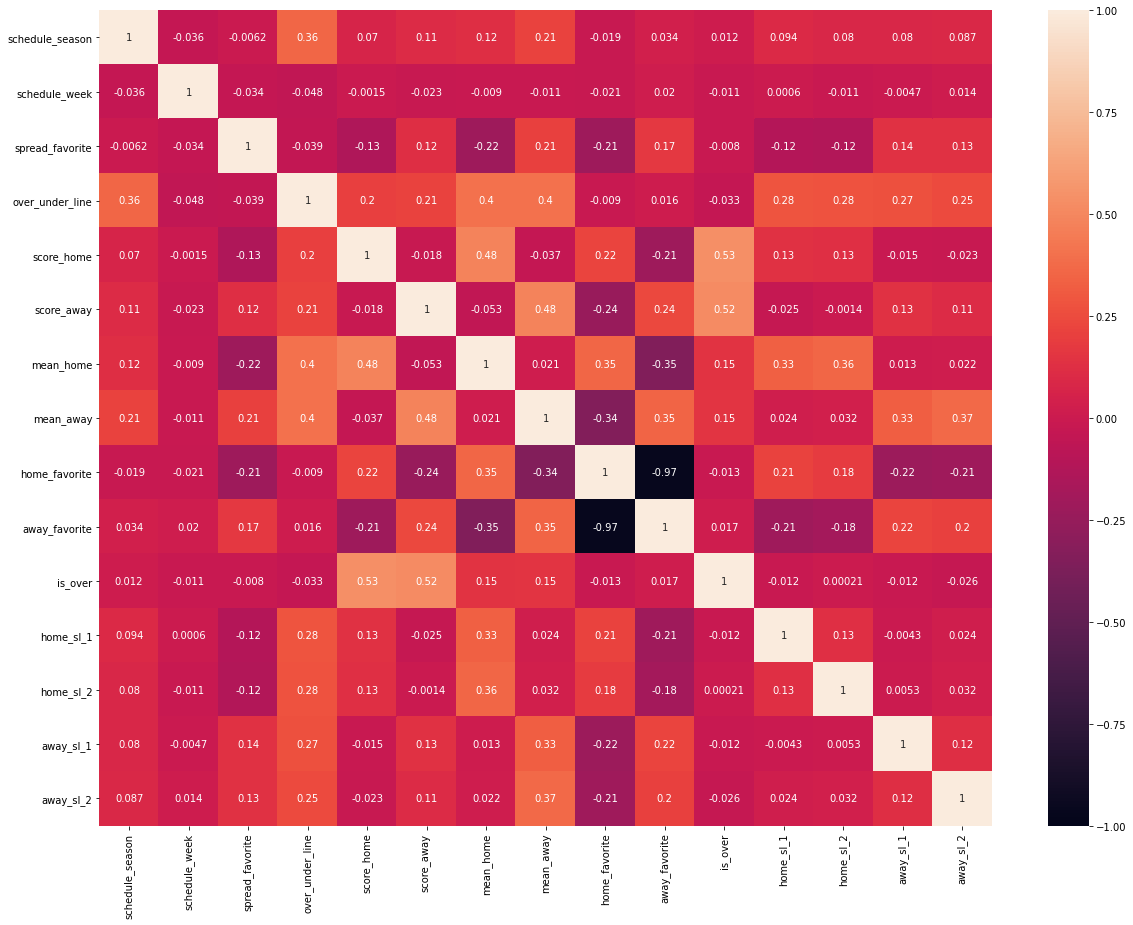

<IPython.core.display.Javascript object>

In [46]:
# corelation heatmap

plt.figure(figsize=(20, 15))
sns.heatmap(dfss.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [47]:
print(dfss.columns)

Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'score_home',
       'score_away', 'mean_home', 'mean_away', 'home_favorite',
       'away_favorite', 'is_over', 'home_sl_1', 'home_sl_2', 'away_sl_1',
       'away_sl_2'],
      dtype='object')


<IPython.core.display.Javascript object>

### Modeling 

In [53]:
X = dfss.drop(
    columns=[
        "is_over",
        "schedule_season",
        # "over_under_line",
        "home_favorite",
        "away_favorite",
        "score_home",
        "score_away",
    ]
)
y = dfss["is_over"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [76]:
# This is code to visualize relationships between features.

encoded = LeaveOneOutEncoder().fit_transform(X_train, y_train)
# df_train = pd.concat((encoded, y_train), axis=1)
# sns.pairplot(df_train[["score_home", "score_away", "is_over"]], hue="is_over")
# plt.show()
# tall_df_train = df_train.melt(id_vars="is_over")
# fg = sns.FacetGrid(tall_df_train, col="variable", col_wrap=4)
# fg.map(sns.boxplot, "is_over", "value")
# plt.show()
display(encoded.head())
prep.fit_transform(X_train, y_train)[3, :]

,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,mean_home,mean_away,home_sl_1,home_sl_2,away_sl_1,away_sl_2
426,12,0.558974,0.514563,0.537572,-3.0,42.0,21.750,21.125000,10.0,13.0,12.0,17.0
1593,12,0.436275,0.489474,0.482234,-1.5,38.0,20.625,19.000000,31.0,11.0,27.0,3.0
805,15,0.470270,0.430000,0.447761,-12.0,46.0,18.250,30.777778,15.0,7.0,34.0,28.0
410,15,0.438503,0.515152,0.492611,-2.0,45.0,22.500,34.000000,24.0,31.0,27.0,34.0
6271,6,0.533333,0.458333,0.482234,-10.0,47.0,26.800,32.888889,27.0,26.0,20.0,38.0


array([15.        ,  0.43850267,  0.51515152,  0.49261084, -2.        ,
       45.        , 22.5       , 34.        , 24.        , 31.        ,
       27.        , 34.        ])

<IPython.core.display.Javascript object>

In [75]:
bin_cols = ["is_over"]  # "home_favorite", "away_favorite"#
num_cols = [
    "mean_home",
    "mean_away",
    "spread_favorite",
    "over_under_line",
    "home_sl_1",
    "home_sl_2",
    "away_sl_1",
    "away_sl_2"
    # "total_pts",
]
cat_cols = [
    "schedule_week",
    "team_home",
    "team_away",
    "team_favorite_id",
]

prep = ColumnTransformer(
    [
        ("leave_one", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [55]:
transformed = prep.fit_transform(X_train, y_train)
# ToDO get printVIF and run it.
type(transformed)
# ToD0, create dataframe with transformed.
transformed = pd.DataFrame(transformed, columns=X_train.columns)
print_vif(transformed)

VIF results
-------------------------------
const               437.393028
schedule_week         1.004499
team_home             1.170686
team_away             1.189183
team_favorite_id      1.024439
spread_favorite       1.134762
over_under_line       1.669317
mean_home             1.451693
mean_away             1.461134
home_sl_1             1.183303
home_sl_2             1.189882
away_sl_1             1.184051
away_sl_2             1.184953
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [56]:
# Try SVC
pipe = Pipeline([("prep", prep), ("svc", SVC())])

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.001, 0.01, 0.1, 1],
}

pipe_cv = GridSearchCV(pipe, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and Eval

In [57]:
pipe_cv.fit(X_train, y_train)

print("Best params:")
print(pipe_cv.best_params_)

print(f"\ntrain score: {pipe_cv.score(X_train,y_train):.3f}")
print(f"test score: {pipe_cv.score(X_test, y_test):.3f}\n")

y_pred = pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 0.01, 'svc__degree': 2, 'svc__kernel': 'linear'}

train score: 0.630
test score: 0.597

[[478 295]
 [308 416]]
              precision    recall  f1-score   support

         0.0       0.61      0.62      0.61       773
         1.0       0.59      0.57      0.58       724

    accuracy                           0.60      1497
   macro avg       0.60      0.60      0.60      1497
weighted avg       0.60      0.60      0.60      1497



<IPython.core.display.Javascript object>

### Feature Importance 

In [58]:
# Turn back on if switches back to linear
coef = pipe_cv.best_estimator_["svc"].coef_[0]
im_df = pd.DataFrame({"feature": X_train.columns, "coef_sq": coef ** 2})
im_df.sort_values("coef_sq", ascending=False)

,feature,coef_sq
7,mean_away,0.025915
6,mean_home,0.020451
5,over_under_line,0.013783
3,team_favorite_id,0.001415
2,team_away,0.000440
1,team_home,0.000434
11,away_sl_2,0.000362
0,schedule_week,0.000334
8,home_sl_1,0.000155
9,home_sl_2,0.000146


<IPython.core.display.Javascript object>

### Error Analysis

In [59]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of over for errors: {errors["is_over"].mean()}')


# sns.swarmplot(y=errors["is_over"])
# plt.show()
# TODO predict_proba_

mean prob of over for errors: 0.4461028192371476


<IPython.core.display.Javascript object>

### Try XGBoost

In [60]:
n_trees = 100
# learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)

x_pipe = Pipeline(
    [
        ("prep", prep),
        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
    ]
)

x_grid = {
    "xgb__subsample": [0.5, 0.75, 1],
    "xgb__colsample_bytree": [0.5, 0.75, 1],
    "xgb__max_depth": [2, 3, 4, 5],
}

x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

In [61]:
x_pipe_cv.fit(X_train, y_train)

print("Best params:")
print(x_pipe_cv.best_params_)

print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")

y_predx = x_pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_predx))
print(classification_report(y_test, y_predx))

/Users/JasonB/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:52:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:
{'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 3, 'xgb__subsample': 1}

train score: 0.487
test score: 0.504

[[489 284]
 [459 265]]
              precision    recall  f1-score   support

         0.0       0.52      0.63      0.57       773
         1.0       0.48      0.37      0.42       724

    accuracy                           0.50      1497
   macro avg       0.50      0.50      0.49      1497
weighted avg       0.50      0.50      0.49      1497



<IPython.core.display.Javascript object>

In [62]:
importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,features,importance
1,team_home,0.372827
2,team_away,0.248365
3,team_favorite_id,0.107010
7,mean_away,0.091730
6,mean_home,0.087966
5,over_under_line,0.049436
11,away_sl_2,0.026217
8,home_sl_1,0.016448
0,schedule_week,0.000000
4,spread_favorite,0.000000


<IPython.core.display.Javascript object>

mean prob of over for errors: 0.48048452220726784


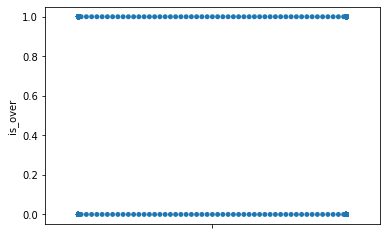

<IPython.core.display.Javascript object>

In [63]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_predx

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of over for errors: {errors["is_over"].mean()}')


sns.swarmplot(y=errors["is_over"])
plt.show()

## Rearrange the model for betting favorite

In [ ]:
#dfss.loc[dfss["team_home"] == dfss["team_favorite_id"]
# dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_away"], "away_favorite"] = 1
# dfss["home_favorite_won"].fillna(0, inplace=True)
# dfscore["away_favorite"].fillna(0, inplace=True)

In [ ]:
dfss.head()
#To DO 
# - create a column to show when the favorite won, ideally output home or away if won, and 0 in fav lost

In [ ]:
X = dfss.drop(
    columns=[
        "is_over",
        "schedule_season",
        # "over_under_line",
        "total_pts",
        "home_favorite",
        "away_favorite",
        "score_home",
        "score_away",
    ]
)
y = dfss["is_over"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
bin_cols = ["is_over"]  # "home_favorite", "away_favorite"#
num_cols = [
    "mean_home",
    "mean_away",
    "spread_favorite",
    "over_under_line",
    # "total_pts",
]
cat_cols = [
    "schedule_week",
    "team_home",
    "team_favorite_id",
    "team_away",
]

prep = ColumnTransformer(
    [
        ("leave_one", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

In [ ]:
transformed = prep.fit_transform(X_train, y_train)
# ToDO get printVIF and run it.
type(transformed)
# ToD0, create dataframe with transformed.
transformed = pd.DataFrame(transformed, columns=X_train.columns)
print_vif(transformed)

In [ ]:
n_trees = 100
# learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)

x_pipe = Pipeline(
    [
        ("prep", prep),
        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
    ]
)

x_grid = {
    "xgb__subsample": [0.5, 0.75, 1],
    "xgb__colsample_bytree": [0.5, 0.75, 1],
    "xgb__max_depth": [2, 3, 4, 5],
}

x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=2, n_jobs=-1)

In [ ]:
x_pipe_cv.fit(X_train, y_train)

print("Best params:")
print(x_pipe_cv.best_params_)

print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")

y_predx = x_pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_predx))
print(classification_report(y_test, y_predx))

In [ ]:
importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

In [ ]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_predx

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of over for errors: {errors["is_over"].mean()}')


sns.swarmplot(y=errors["is_over"])
plt.show()

In [ ]:
# for column_name in ['schedule_week', 'over_under_line']:
#    print("These are the problematic values for the variable: {}".format(column_name))
#    for value in dfscore[column_name]:
#        try:
#            float(value)
#        except:
#            print(value)